In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statsmodels.api as sm
import pylab as py


from sklearn.impute import SimpleImputer as Imputer

from sklearn import tree


from sklearn.model_selection import cross_val_score


# Einflussfaktoren auf Anzahl der Drogentoten in den Staaten der EU 

Mit Hilfe der linearen regression möchten wir untersuchen, ob es Zusammenhänge zwichen einzelnen gesellschaftlichen Faktoren auf die Anzahl der Drogentoten eines Landes gibt.


Wir untersuchen die Stärke der Korellation durch den Pearson Koeffizienten und bewerten die Aussagekraft des Wertes anhand des p-Wertes. Als Signifikanzniveau wird hierfür 0.05 festgelegt.

<hr>

## Laden der CSV Datei und finale Datenformatierung

* Datenbeschaffung wurde von anderen Mitgliedern der Gruppe durchgeführt.
* Formatierung in Vergleichbare Einheiten ( pro 100_000 Einwohner)
* Entfernen von nicht berücksichtigten Werten


In [21]:


df = pd.read_excel('data_collection_2016 .xlsx')

# Drogentote/Alkoholtote auf 100_000 Einwohner // Am Anfang einordnen

df['Alkohol Tote'] = (df["Alkohol Tote"]/df.Bevölkerung)*100_000
df['Drogentote'] = (df.Drogentote/df.Bevölkerung)*100_000
df = df.rename(columns={"Alkohol Tote": "Alkoholtote",
               'Psychiatriebetten pro 100t': 'Psychiatriebetten'})

df.insert(1, 'Drogentote', df.pop('Drogentote'))

# Arbeitslosenquote in %
df.Arbeitslosenquote = df.Arbeitslosenquote/100

# Nicht relevante Daten entfernen
df = df.drop(['Bevölkerung', 'Spritzenprogramm', 'Absolute Todeszahlen', 'Sonnenstunden / Jahr', 'Drugchecking', 'Drogendelikte', 'Geringe Menge', 'Oberstes/Unterstes Quintel',
             'Durschnittliches Äquivalenzeinkommen', 'Substitutionsprogramme', 'Gefängnisinsassen', 'Erwerbstätigenquote', 'Konsumräume', 'Drogendelikte', 'Konsum erlaubt', 'Gefängnisinsassen'], axis=1)
df = df.drop(df[df.Land == 'Norwegen'].index)
df


,Land,Drogentote,Alkoholtote,Psychiatriebetten,Scheidungsziffer,Arbeitslosenquote,Bildungsabschluss,BIP,Gini-Koeffizient,World Happiness Report,Akzeptanzfaktor
0,Belgien,1.220039,27.839868,140.92,2.1,0.047,71.8,37960,26.3,6.891,5
1,Bulgarien,0.307530,39.867013,57.14,1.5,0.051,78.1,6840,37.7,4.714,2
2,Tschechien,0.303207,33.892867,92.48,2.4,0.026,87.6,16790,25.1,6.609,3
3,Dänemark,4.485522,26.317399,39.72,3.0,0.041,72.7,49420,27.7,7.522,5
4,Deutschland,1.622134,33.020717,127.54,2.0,0.027,80.2,38070,29.5,6.951,5
5,Estland,8.662983,31.916252,51.00,2.5,0.049,82.7,15520,32.7,5.611,3
6,Irland,4.675976,19.275177,34.28,0.7,0.056,77.0,56900,29.6,6.977,2
7,Griechenland,2.095746,22.867745,70.75,1.0,0.142,70.0,16190,34.3,5.227,2
8,Spanien,1.040049,24.709250,35.52,2.1,0.128,57.4,23990,34.5,6.403,5
9,Frankreich,0.697796,27.008455,85.93,1.9,0.063,74.5,33430,29.3,6.442,4


# Boxplot

Boxplot zur Darstellung von eventuellen Extremwerten innerhalb des Datensatzes.


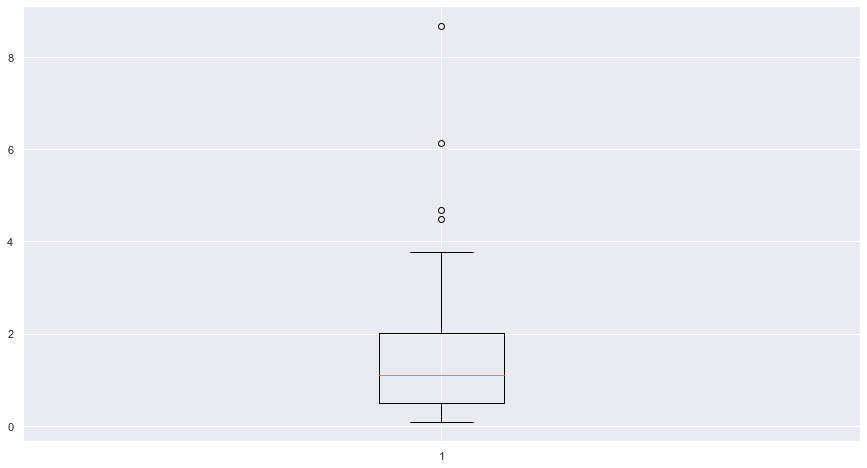

In [24]:
plt.boxplot(df['Drogentote'])
plt.show()

Wie im Boxplot zu erkennen gibt es mehrere Extremwerte, mit speziell einem der sehr stark abweicht.
Im nächsten Schritt lassen wir uns die Länder anzeigen welche diese 4 Extremwerte darstellen.

In [23]:
df.nlargest(4, 'Drogentote')

,Land,Drogentote,Alkoholtote,Psychiatriebetten,Scheidungsziffer,Arbeitslosenquote,Bildungsabschluss,BIP,Gini-Koeffizient,World Happiness Report,Akzeptanzfaktor
5,Estland,8.662983,31.916252,51.00,2.5,0.049,82.7,15520,32.7,5.611,3
26,Schweden,6.141498,16.536364,43.24,2.4,0.051,78.9,46990,27.6,7.284,2
6,Irland,4.675976,19.275177,34.28,0.7,0.056,77.0,56900,29.6,6.977,2
3,Dänemark,4.485522,26.317399,39.72,3.0,0.041,72.7,49420,27.7,7.522,5


Um die Auswirkungen von Estland auf die Lagemaße zu bewerten, betrachten wir den Mittelwert, Median und die Standardabweichung der Daten mit und ohne Estland.

## Lagemaße


Inklusive Estland

In [7]:
columns = ['Drogentote']

df_values = pd.DataFrame(columns=columns)

mean = []
median = []
std = []

mean.append(df['Drogentote'].mean())
median.append(df['Drogentote'].median())
std.append(df['Drogentote'].std())

df_values.loc[len(df_values.index)] = mean
df_values.loc[len(df_values.index)] = median
df_values.loc[len(df_values.index)] = std
df_values.insert(0, 'Kennzahl', ['Mittelwert', 'Median', 'Standardabweichung'])
df_values




,Kennzahl,Drogentote
0,Mittelwert,1.879414
1,Median,1.110087
2,Standardabweichung,2.071423


Exklusive Estland

In [6]:
df_noEst = df.drop(df[df.Land == 'Estland'].index)


df_values = pd.DataFrame(columns=columns)

mean = []
median = []
std = []
for e in columns:
    mean.append(df_noEst['Drogentote'].mean())
    median.append(df_noEst['Drogentote'].median())
    std.append(df_noEst['Drogentote'].std())

df_values.loc[len(df_values.index)] = mean
df_values.loc[len(df_values.index)] = median
df_values.loc[len(df_values.index)] = std
df_values.insert(0, 'Kennzahl', ['Mittelwert', 'Median', 'Standardabweichung'])
df_values


,Kennzahl,Drogentote
0,Mittelwert,1.618507
1,Median,1.075068
2,Standardabweichung,1.597171


Ohne Estland zeigt sich eine Verbesserung der Standardabweichung. Somit wird es in der weiteren Auswertung nicht berücksichtigt.

In [8]:
df = df.drop(df[df.Land == 'Estland'].index)


## Korellationsmatrix


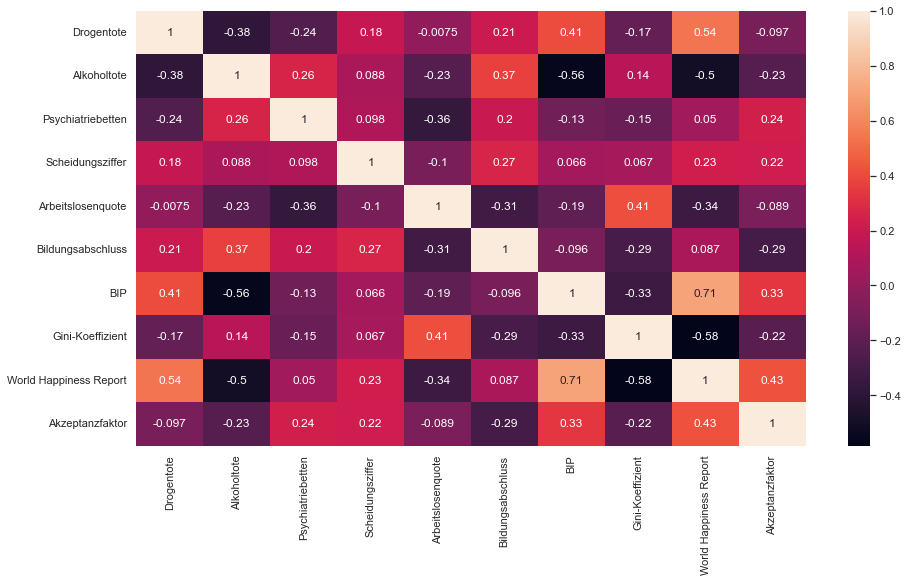

In [9]:
sns.set(rc={'figure.figsize': (15, 8)})
sns.heatmap(df.corr(), annot=True)
plt.savefig('CorrMatrixOhneE')


## Lineare Regression


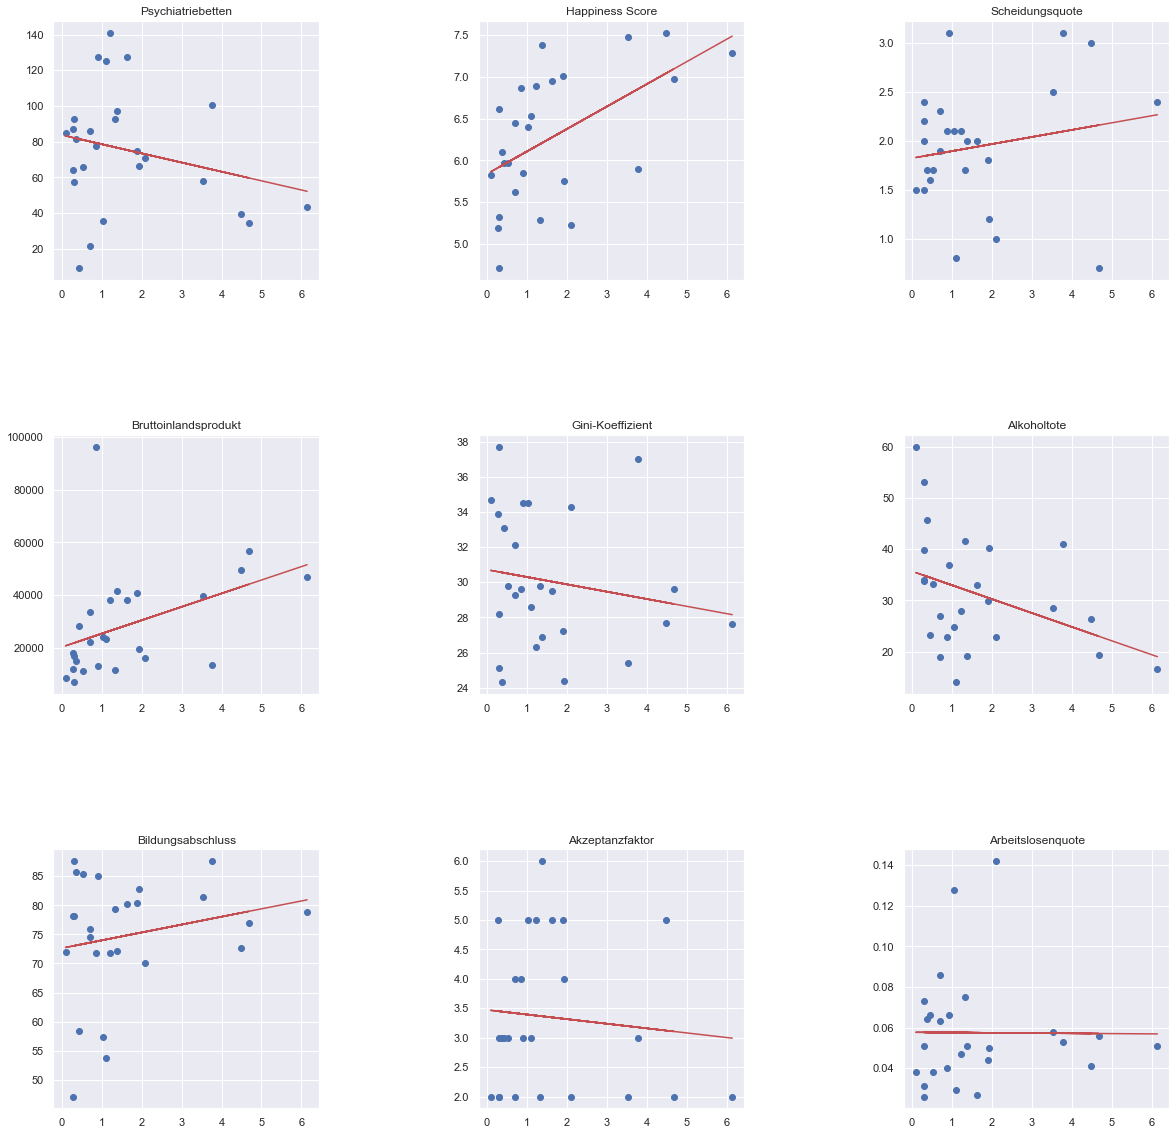

In [17]:
# Zeichenfläche und Subplots

fig, axs = plt.subplots(3,3, figsize=(20,20))
plt.subplots_adjust(hspace=0.6, wspace=0.6)





# Drogentote vs. Psychiatriebetten
drogentote = df['Drogentote']
psychiatriebetten = df['Psychiatriebetten']
slope, intercept, r_value, p_value, stderr = stats.linregress(
    drogentote, psychiatriebetten)
psychiatriebetten_values = ["Psychiatriebetten", r_value, p_value]

axs[0,0].scatter(drogentote, psychiatriebetten)
axs[0,0].set_title("Psychiatriebetten")

axs[0,0].plot(drogentote, (slope*drogentote)+intercept, 'r')


# Drogentote vs. Happinessfaktor

happiness = df['World Happiness Report']
slope, intercept, r_value, p_value, stderr = stats.linregress(drogentote, happiness)
happiness_values = ["Happiness", r_value, p_value]

axs[0,1].scatter(drogentote, happiness)
axs[0,1].set_title("Happiness Score")
axs[0,1].plot(drogentote, slope*drogentote+intercept, 'r')

# Drogentote vs. Scheidungsziffer

scheidung = df['Scheidungsziffer']
slope, intercept, r_value, p_value, stderr = stats.linregress(drogentote,scheidung )
scheidung_values = ["Scheidungsquote", r_value, p_value]

axs[0,2].scatter(drogentote, scheidung)
axs[0,2].set_title("Scheidungsquote")
axs[0,2].plot(drogentote, slope*drogentote+intercept, 'r')

# Drogentote vs. BIP

bip = df['BIP']
slope, intercept, r_value, p_value, stderr = stats.linregress(drogentote, bip)
bip_values = ["BIP", r_value, p_value]

axs[1,0].scatter(drogentote, bip)
axs[1,0].set_title("Bruttoinlandsprodukt")
axs[1,0].plot(drogentote, slope*drogentote+intercept, 'r')

# Drogentote vs. GINI

gini = df['Gini-Koeffizient']
slope, intercept, r_value, p_value, stderr = stats.linregress(drogentote, gini)
gini_values = ["Gini", r_value, p_value]

axs[1,1].scatter(drogentote, gini)
axs[1,1].set_title("Gini-Koeffizient")
axs[1,1].plot(drogentote, slope*drogentote+intercept, 'r')

# Drogentote vs. Alkoholtote

alkoholtote = df['Alkoholtote']
slope, intercept, r_value, p_value, stderr = stats.linregress(drogentote, alkoholtote)
alk_values = ["Alkoholtote", r_value, p_value]

axs[1,2].scatter(drogentote,alkoholtote)
axs[1,2].set_title("Alkoholtote")
axs[1,2].plot(drogentote, slope*drogentote+intercept, 'r')


# Drogentote vs. Bildungsabschluss
bildung = df['Bildungsabschluss']
slope, intercept, r_value, p_value, stderr = stats.linregress(drogentote, bildung)
bildung_values = ['Bildungsabschluss', r_value, p_value]

axs[2,0].scatter(drogentote, bildung)
axs[2,0].set_title("Bildungsabschluss")
axs[2,0].plot(drogentote, slope*drogentote+intercept, 'r')

# Drogentote vs. Akzeptanzfaktor

akzeptanz = df['Akzeptanzfaktor']
slope, intercept, r_value, p_value, stderr = stats.linregress(drogentote, akzeptanz)
akzeptanz_values = ['Akzeptanzfaktor', r_value, p_value]

axs[2,1].scatter(drogentote,akzeptanz)
axs[2,1].set_title("Akzeptanzfaktor")
axs[2,1].plot(drogentote, slope*drogentote+intercept, 'r')

# Drogentote vs. Arbeitslosenquote

arbeitslose = df['Arbeitslosenquote']
slope, intercept, r_value, p_value, stderr = stats.linregress(drogentote, arbeitslose)
arbeitslose_values = ['Arbeitslosenquote', r_value, p_value]

axs[2,2].scatter(drogentote, arbeitslose)
axs[2,2].set_title("Arbeitslosenquote")
axs[2,2].plot(drogentote, slope*drogentote+intercept, 'r')



## Pearson Koeffizient und p-Wert




In [14]:
df_kennzahlen_NoEstland = pd.DataFrame(
    columns=["Name", "Pearson Coefficient", "p-wert(Pearson)"])

df_kennzahlen_NoEstland.loc[len(df_kennzahlen_NoEstland.index)] = psychiatriebetten_values
df_kennzahlen_NoEstland.loc[len(df_kennzahlen_NoEstland.index)] = happiness_values
df_kennzahlen_NoEstland.loc[len(df_kennzahlen_NoEstland.index)] = gini_values
df_kennzahlen_NoEstland.loc[len(df_kennzahlen_NoEstland.index)] = bip_values
df_kennzahlen_NoEstland.loc[len(df_kennzahlen_NoEstland.index)] = alk_values
df_kennzahlen_NoEstland.loc[len(df_kennzahlen_NoEstland.index)] = scheidung_values
df_kennzahlen_NoEstland.loc[len(df_kennzahlen_NoEstland.index)] = bildung_values
df_kennzahlen_NoEstland.loc[len(df_kennzahlen_NoEstland.index)] = akzeptanz_values
df_kennzahlen_NoEstland.loc[len(df_kennzahlen_NoEstland.index)] = arbeitslose_values
df_kennzahlen_NoEstland


,Name,Pearson Coefficient,p-wert(Pearson)
0,Psychiatriebetten,-0.244539,0.228601
1,Happiness,0.540705,0.004345
2,Gini,-0.171774,0.401432
3,BIP,0.411489,0.036749
4,Alkoholtote,-0.384167,0.052669
5,Scheidungsquote,0.184110,0.367940
6,Bildungsabschluss,0.206612,0.311210
7,Akzeptanzfaktor,-0.096617,0.638696
8,Arbeitslosenquote,-0.007535,0.970857


<hr>

# Auswertung

